In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [226]:
# Sam's special methods to display large DataFrames
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

## Tidy Data

Based off Hadley Wickham's _R for Data Science_ book: https://r4ds.had.co.nz/tidy-data.html

In [241]:
tb = pd.read_csv('who.csv')
# tb

In [227]:
df_interact(tb)

interactive(children=(IntSlider(value=0, description='row', max=7240, step=7), IntSlider(value=0, description=…

(7240 rows, 18 columns) total


In [136]:
def drop_iso(df):
    return df.drop(columns=['iso2', 'iso3'])

In [137]:
def make_tidy(df):
    return pd.melt(df, id_vars=['country', 'year'],
                   var_name='entry', value_name='count')

In [140]:
def split_entry(df):
    codes = df['entry'].str.split('_').str[-1]
    return (df.assign(sex=codes.str[0], agecode=codes.str[1:])
            .drop(columns=['entry']))

In [141]:
def age_from_code(df):
    return df.assign(age=df['agecode'].replace({
        '014': '0-14',
        '04': '0-4',
        '1524': '15-24',
        '2534': '25-34',
        '3544': '35-44',
        '4554': '45-54',
        '5564': '55-64',
        '65': '65+',
    })).drop(columns='agecode')

In [142]:
tidy = (tb.pipe(drop_iso)
 .pipe(make_tidy)
 .pipe(split_entry)
 .pipe(age_from_code)
)
tidy

,country,year,count,sex,age
0,Afghanistan,1980,NaN,m,0-14
1,Afghanistan,1981,NaN,m,0-14
2,Afghanistan,1982,NaN,m,0-14
...,...,...,...,...,...
101357,Zimbabwe,2011,160.0,f,65+
101358,Zimbabwe,2012,161.0,f,65+
101359,Zimbabwe,2013,NaN,f,65+


In [238]:
counts = (tidy
 .groupby(['country', 'year'])
 .mean()
 .dropna()
 .reset_index()
 .loc[lambda df: df['country'].str[0] == 'H']
)
counts

,country,year,count
1291,Haiti,1996,239.36
1292,Haiti,1997,389.21
1293,Haiti,1998,460.14
...,...,...,...
1339,Hungary,2010,19.07
1340,Hungary,2011,18.57
1341,Hungary,2012,19.50


Tidy data is especially useful for seaborn, the plotting library we will use extensively in this course!

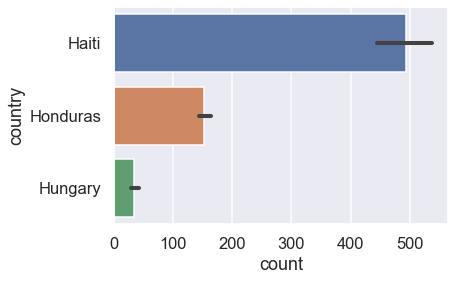

In [243]:
sns.barplot(x='count', y='country', data=counts)

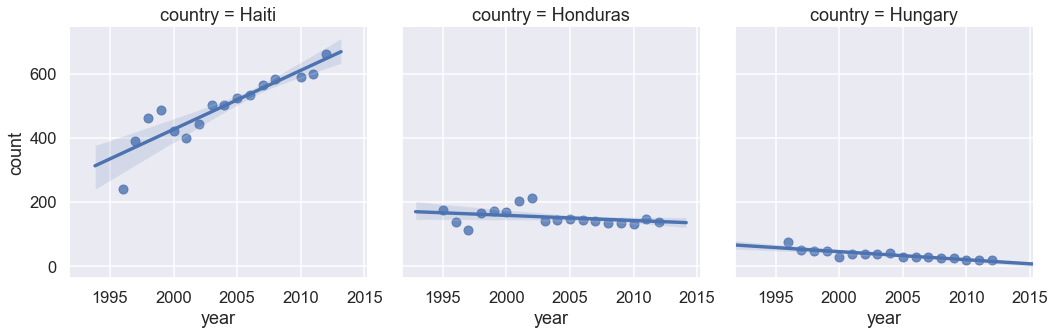

In [252]:
sns.lmplot(x='year', y='count', col='country', data=counts)

## JSON

In [246]:
elections = pd.read_csv("elections.csv")
elections.to_json("elections.json") # orient='table' or 'records' or 'values'
!python -m json.tool elections.json 

{
    "Candidate": {
        "0": "Reagan",
        "1": "Carter",
        "2": "Anderson",
        "3": "Reagan",
        "4": "Mondale",
        "5": "Bush",
        "6": "Dukakis",
        "7": "Clinton",
        "8": "Bush",
        "9": "Perot",
        "10": "Clinton",
        "11": "Dole",
        "12": "Perot",
        "13": "Gore",
        "14": "Bush",
        "15": "Kerry",
        "16": "Bush",
        "17": "Obama",
        "18": "McCain",
        "19": "Obama",
        "20": "Romney",
        "21": "Clinton",
        "22": "Trump"
    },
    "Party": {
        "0": "Republican",
        "1": "Democratic",
        "2": "Independent",
        "3": "Republican",
        "4": "Democratic",
        "5": "Republican",
        "6": "Democratic",
        "7": "Democratic",
        "8": "Republican",
        "9": "Independent",
        "10": "Democratic",
        "11": "Republican",
        "12": "Independent",
        "13": "Democratic",
        "14": "Republican",
        "15": 

## Hierarchical Data

A lot of structured data isn't in CSV format, but in HTML, XML, JSON, YAML, etc. JSON might have a structure that Pandas can't read directly.

Here's an example: a group of people collected information about US congressional legislators in YAML format.

https://github.com/unitedstates/congress-legislators

Here's one of the data files:

https://github.com/unitedstates/congress-legislators/blob/master/legislators-current.yaml

In [20]:
import requests
from pathlib import Path

legislators_path = 'legislators-current.yaml'
base_url = 'https://github.com/unitedstates/congress-legislators/raw/dc6fde4ed65f88edf11568d0522eca17b439f447/'

def download(url, path):
    """Download the contents of a URL to a local file."""
    path = Path(path) # If path was a string, now it's a Path
    if not path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(url)
        with path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
        
download(base_url + legislators_path, legislators_path)

Downloading... Done!


In [21]:
import yaml

legislators = yaml.safe_load(open(legislators_path))
len(legislators)

539

In [23]:
legislators[0]

{'id': {'bioguide': 'B000944',
  'thomas': '00136',
  'lis': 'S307',
  'govtrack': 400050,
  'opensecrets': 'N00003535',
  'votesmart': 27018,
  'fec': ['H2OH13033', 'S6OH00163'],
  'cspan': 5051,
  'wikipedia': 'Sherrod Brown',
  'house_history': 9996,
  'ballotpedia': 'Sherrod Brown',
  'maplight': 168,
  'icpsr': 29389,
  'wikidata': 'Q381880',
  'google_entity_id': 'kg:/m/034s80'},
 'name': {'first': 'Sherrod',
  'last': 'Brown',
  'official_full': 'Sherrod Brown'},
 'bio': {'birthday': '1952-11-09', 'gender': 'M', 'religion': 'Lutheran'},
 'terms': [{'type': 'rep',
   'start': '1993-01-05',
   'end': '1995-01-03',
   'state': 'OH',
   'district': 13,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1995-01-04',
   'end': '1997-01-03',
   'state': 'OH',
   'district': 13,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1997-01-07',
   'end': '1999-01-03',
   'state': 'OH',
   'district': 13,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1999-01-06',
   'end

In [24]:
x = legislators[0]
x['id']

{'bioguide': 'B000944',
 'thomas': '00136',
 'lis': 'S307',
 'govtrack': 400050,
 'opensecrets': 'N00003535',
 'votesmart': 27018,
 'fec': ['H2OH13033', 'S6OH00163'],
 'cspan': 5051,
 'wikipedia': 'Sherrod Brown',
 'house_history': 9996,
 'ballotpedia': 'Sherrod Brown',
 'maplight': 168,
 'icpsr': 29389,
 'wikidata': 'Q381880',
 'google_entity_id': 'kg:/m/034s80'}

In [25]:
x['name']

{'first': 'Sherrod', 'last': 'Brown', 'official_full': 'Sherrod Brown'}

In [26]:
x['bio']

{'birthday': '1952-11-09', 'gender': 'M', 'religion': 'Lutheran'}

In [27]:
from datetime import datetime

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

to_date(x['bio']['birthday'])

datetime.datetime(1952, 11, 9, 0, 0)

In [28]:
leg_df = pd.DataFrame(
    columns=['id', 'first', 'last', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           to_date(x['bio']['birthday'])] for x in legislators])
leg_df.head()

,id,first,last,birthday
0,B000944,Sherrod,Brown,1952-11-09
1,C000127,Maria,Cantwell,1958-10-13
2,C000141,Benjamin,Cardin,1943-10-05
3,C000174,Thomas,Carper,1947-01-23
4,C001070,Robert,Casey,1960-04-13


In [29]:
datetime.now() - leg_df.loc[0, 'birthday']

Timedelta('24335 days 15:57:15.878519')

In [30]:
leg_df['age'] = (datetime.now() - leg_df['birthday']).apply(lambda age: age.days/365)
leg_df.head()

,id,first,last,birthday,age
0,B000944,Sherrod,Brown,1952-11-09,66.67
1,C000127,Maria,Cantwell,1958-10-13,60.74
2,C000141,Benjamin,Cardin,1943-10-05,75.78
3,C000174,Thomas,Carper,1947-01-23,72.47
4,C001070,Robert,Casey,1960-04-13,59.24


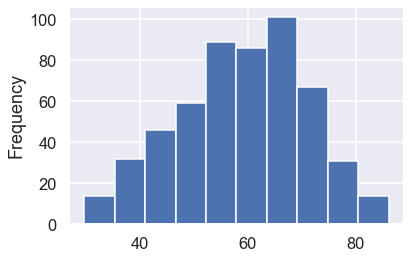

In [31]:
leg_df['age'].plot(kind='hist');

## Missing Values

Note that religion got removed between Spring 2019 and now. https://github.com/unitedstates/congress-legislators/issues/657

We're actually using the last version of the data that still has religion in it.

In [34]:
leg_df['religion'] = [x['bio'].get('religion') for x in legislators]
leg_df

,id,first,last,birthday,age,religion
0,B000944,Sherrod,Brown,1952-11-09,66.67,Lutheran
1,C000127,Maria,Cantwell,1958-10-13,60.74,Roman Catholic
2,C000141,Benjamin,Cardin,1943-10-05,75.78,Jewish
...,...,...,...,...,...,...
536,R000615,Mitt,Romney,1947-03-12,72.34,None
537,M001197,Martha,McSally,1966-03-22,53.30,None
538,G000592,Jared,Golden,1982-07-25,36.95,None


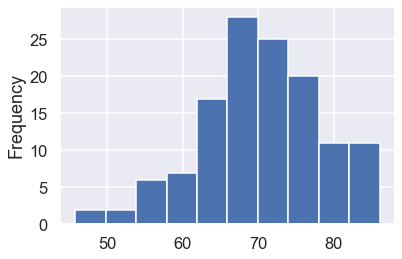

In [35]:
leg_df[leg_df['religion'].notnull()]['age'].plot(kind='hist');

## Joins

In [37]:
comm_path = 'committees-current.yaml'
comm_membership_path = 'committee-membership-current.yaml'
for p in [comm_path, comm_membership_path]:
    download(base_url + p, p)
comms = yaml.safe_load(open(comm_path))
comm_membership = yaml.safe_load(open(comm_membership_path))
print(len(comms), len(comm_membership))

47 217


In [38]:
comms[0]

{'type': 'house',
 'name': 'House Committee on Agriculture',
 'url': 'https://agriculture.house.gov/',
 'minority_url': 'https://democrats-agriculture.house.gov/',
 'thomas_id': 'HSAG',
 'house_committee_id': 'AG',
 'subcommittees': [{'name': 'Conservation and Forestry',
   'thomas_id': '15',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
  {'name': 'Commodity Exchanges, Energy, and Credit',
   'thomas_id': '22',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
  {'name': 'General Farm Commodities and Risk Management',
   'thomas_id': '16',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
  {'name': 'Livestock and Foreign Agriculture',
   'thomas_id': '29',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
  {'name': 'Biotechnology, Horticulture, and Research',
   'thomas_id': '14',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
 

In [40]:
comm_df = pd.DataFrame(
    columns=['name', 'thomas_id', 'type'],
    data=[[c['name'], c['thomas_id'], c['type']] for c in comms]
)
comm_df

,name,thomas_id,type
0,House Committee on Agriculture,HSAG,house
1,House Committee on Appropriations,HSAP,house
2,House Committee on Armed Services,HSAS,house
...,...,...,...
44,Senate Committee on Rules and Administration,SSRA,senate
45,Senate Committee on Small Business and Entrepr...,SSSB,senate
46,Senate Committee on Veterans' Affairs,SSVA,senate


In [41]:
comm_membership.keys()

dict_keys(['HLIG', 'HLIG01', 'HLIG02', 'HLIG03', 'HLIG04', 'HSAG', 'HSAG03', 'HSAG14', 'HSAG15', 'HSAG16', 'HSAG22', 'HSAG29', 'HSAP', 'HSAP01', 'HSAP02', 'HSAP04', 'HSAP06', 'HSAP07', 'HSAP10', 'HSAP15', 'HSAP18', 'HSAP19', 'HSAP20', 'HSAP23', 'HSAP24', 'HSAS', 'HSAS02', 'HSAS03', 'HSAS06', 'HSAS25', 'HSAS26', 'HSAS28', 'HSAS29', 'HSBA', 'HSBA01', 'HSBA04', 'HSBA09', 'HSBA15', 'HSBA16', 'HSBA20', 'HSBU', 'HSED', 'HSED02', 'HSED10', 'HSED13', 'HSED14', 'HSFA', 'HSFA05', 'HSFA07', 'HSFA13', 'HSFA14', 'HSFA16', 'HSFA18', 'HSGO', 'HSGO06', 'HSGO24', 'HSGO25', 'HSGO27', 'HSGO28', 'HSGO29', 'HSHA', 'HSHM', 'HSHM05', 'HSHM07', 'HSHM08', 'HSHM09', 'HSHM11', 'HSHM12', 'HSIF', 'HSIF02', 'HSIF03', 'HSIF14', 'HSIF16', 'HSIF17', 'HSIF18', 'HSII', 'HSII06', 'HSII10', 'HSII13', 'HSII15', 'HSII24', 'HSJU', 'HSJU01', 'HSJU03', 'HSJU05', 'HSJU08', 'HSJU10', 'HSPW', 'HSPW02', 'HSPW05', 'HSPW07', 'HSPW12', 'HSPW13', 'HSPW14', 'HSRU', 'HSRU02', 'HSRU04', 'HSSM', 'HSSM23', 'HSSM24', 'HSSM25', 'HSSM26', 'HS

In [42]:
comm_membership['HSAG'][0]

{'name': 'K. Michael Conaway',
 'party': 'majority',
 'rank': 1,
 'title': 'Chair',
 'thomas': '01805',
 'bioguide': 'C001062'}

In [43]:
member_df = pd.DataFrame(
    columns=['comm_id', 'leg_id'],
    data=[[c, m['bioguide']] for c, members in comm_membership.items() for m in members]
)
member_df.head()

,comm_id,leg_id
0,HLIG,N000181
1,HLIG,C001062
2,HLIG,K000210
3,HLIG,T000463
4,HLIG,W000815


In [44]:
member_comm = member_df.merge(comm_df, left_on='comm_id', right_on='thomas_id')
member_comm.head()

,comm_id,leg_id,name,thomas_id,type
0,HLIG,N000181,House Permanent Select Committee on Intelligence,HLIG,house
1,HLIG,C001062,House Permanent Select Committee on Intelligence,HLIG,house
2,HLIG,K000210,House Permanent Select Committee on Intelligence,HLIG,house
3,HLIG,T000463,House Permanent Select Committee on Intelligence,HLIG,house
4,HLIG,W000815,House Permanent Select Committee on Intelligence,HLIG,house


In [45]:
comm_sizes = member_comm['name'].value_counts()
comm_sizes

House Committee on Armed Services                                 48
House Committee on Energy and Commerce                            48
House Committee on Transportation and Infrastructure              47
                                                                  ..
Senate Select Committee on Ethics                                  6
Joint Committee on Taxation                                        5
United States Senate Caucus on International Narcotics Control     5
Name: name, Length: 47, dtype: int64

In [47]:
df = member_comm.merge(leg_df, left_on='leg_id', right_on='id')
df

,comm_id,leg_id,name,thomas_id,...,last,birthday,age,religion
0,HLIG,N000181,House Permanent Select Committee on Intelligence,HLIG,...,Nunes,1973-10-01,45.76,Roman Catholic
1,HSWM,N000181,House Committee on Ways and Means,HSWM,...,Nunes,1973-10-01,45.76,Roman Catholic
2,HLIG,C001062,House Permanent Select Committee on Intelligence,HLIG,...,Conaway,1948-06-11,71.09,Baptist
...,...,...,...,...,...,...,...,...,...
1061,SSGA,P000603,Senate Committee on Homeland Security and Gove...,SSGA,...,Paul,1963-01-07,56.50,None
1062,SSHR,P000603,"Senate Committee on Health, Education, Labor, ...",SSHR,...,Paul,1963-01-07,56.50,None
1063,SSSB,P000603,Senate Committee on Small Business and Entrepr...,SSSB,...,Paul,1963-01-07,56.50,None


In [48]:
comm_ages = df['age'].groupby(df['name']).mean().sort_values()
comm_ages

name
House Permanent Select Committee on Intelligence                  55.20
House Committee on House Administration                           55.31
Joint Economic Committee                                          55.56
                                                                  ...  
Joint Committee on Taxation                                       71.53
Joint Committee on the Library                                    74.02
United States Senate Caucus on International Narcotics Control    75.85
Name: age, Length: 47, dtype: float64

In [49]:
leg_df['age'].mean()

59.02013368236462

In [50]:
member_count = member_df['leg_id'].value_counts().to_frame().reset_index()
member_count.head()

,index,leg_id
0,L000174,24
1,S000320,23
2,M000934,22
3,C001047,22
4,U000039,21


In [51]:
member_count.columns = ['id', 'num_comms']
member_count.head()

,id,num_comms
0,L000174,24
1,S000320,23
2,M000934,22
3,C001047,22
4,U000039,21


In [52]:
df = leg_df.merge(member_count, left_on='id', right_on='id')
df.head()

,id,first,last,birthday,age,religion,num_comms
0,B000944,Sherrod,Brown,1952-11-09,66.67,Lutheran,14
1,C000127,Maria,Cantwell,1958-10-13,60.74,Roman Catholic,16
2,C000141,Benjamin,Cardin,1943-10-05,75.78,Jewish,14
3,C000174,Thomas,Carper,1947-01-23,72.47,Presbyterian,12
4,C001070,Robert,Casey,1960-04-13,59.24,None,12


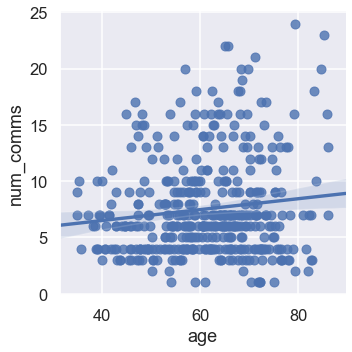

In [53]:
import seaborn as sns
sns.lmplot(x='age', y='num_comms', data=df, fit_reg=True);